# Homework 04 - Francesco Ortu

In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pyro.infer.mcmc import MCMC, HMC, NUTS

## Ex 1

----
Let $\theta_1$ and $\theta_2$ be real valued parameters in $[0,1]$ and consider the generative model
\begin{align*}
\theta_1 &\sim \theta_1\text{-prior}\\
\theta_2 &\sim \theta_2\text{-prior}\\
\hat{y} &= \frac{\theta_1+x^2}{\theta_2\cdot x}\\
y &\sim \mathcal{N} (\hat{y}, 1)
\end{align*}

a. Use pyro to implement the model as a function `model(theta1_prior, theta2_prior, x, obs)`, where `theta1_prior` and `theta2_prior` are pyro.distributions objects, `x` and `obs` are torch tensors, and draws from the normal distribution are conditioned on `obs`.

b. Choose two suitable prior distributions for $\theta_1$ and $\theta_2$ (e.g. suitably rescaled Normal or Beta distributions)  and use HMC or NUTS algorithm to find their posterior distributions given the observations

\begin{align*}
x&=(47,87,20,16,38,5)\\
y&=(58.76, 108.75,  25.03,  20.03,  47.51,  6.37).
\end{align*}


c. Discuss how different prior distributions lead to different estimates of $\theta_1$ and $\theta_2$. Comment on the convergence checks and plot the posterior distributions. 

-----

In [106]:
def model(theta1_prior, theta2_prior):

    def model_(x):
        theta_1 = pyro.sample('theta_1', theta1_prior)
        theta_2 = pyro.sample('theta_2', theta2_prior)
        y = pyro.sample('y', dist.Normal(( theta_1 + x**2 ) / ( theta_2 * x ), 1))
        return y, theta_1, theta_2
    return model_

def plot_dist(dist1, dist2):
    y_1 = dist1.sample((10000,))
    y_2 = dist2.sample((10000,))
    data = pd.DataFrame({"prior_theta1":y_1, "prior_theta2":y_2})
    sns.displot(data, kind='kde')

def plot_inference(mcmc_samples):
    print("expected theta1 =", mcmc_samples['theta_1'].mean().item())
    print("expected theta2 =", mcmc_samples['theta_2'].mean().item())

    y_1 = np.reshape(mcmc_samples["theta_1"].numpy(), mcmc_samples["theta_1"].size()[1])
    y_2 = np.reshape(mcmc_samples["theta_2"].numpy(), mcmc_samples["theta_2"].size()[1])
    # fig, ax = plt.subplots(1, 2, figsize=(12,3))
    # sns.distplot(y_1, label="theta1")
    # sns.distplot(y_2, label="theta2")
    data = pd.DataFrame({"theta1":y_1, "theta2":y_2})
    sns.displot(data, kind="kde")
    
def compute_mcmc(model, x, Kernel=NUTS):
    kernel = Kernel(model=model) # transition kernel
    mcmc = MCMC(kernel, num_samples=100, warmup_steps=300, num_chains=1)
    mcmc.run(x=x)
    print(mcmc.get_samples().keys())
    mcmc_samples = mcmc.get_samples(group_by_chain=True)
    print(mcmc.summary())
    return mcmc_samples
    

In [3]:
#generate the data
x = torch.Tensor([47,87,20,16,38,5])
y = torch.Tensor([58.76,108.75,25.03,20.03,47.51,6.37])

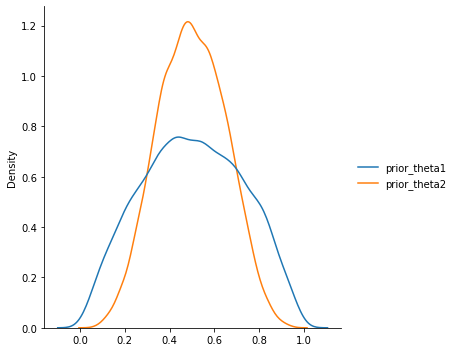

In [74]:
#### beta distribution
theta1_beta = dist.Beta(2,2)
theta2_beta = dist.Beta(5,5)
plot_dist(theta1_beta, theta2_beta)


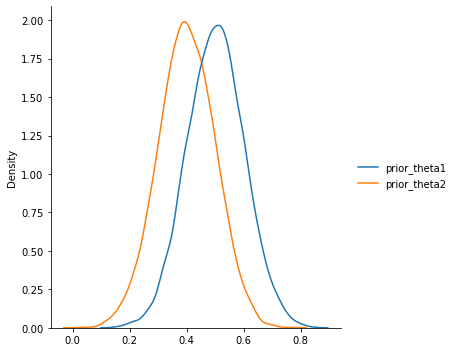

In [5]:
### Gaussian distributions
theta1_gauss = dist.Normal(0.5,0.1)
theta2_gauss = dist.Normal(0.4,0.1)
plot_dist(theta1_gauss, theta2_gauss)

__??__ Why with HMC the computation is blocked around 104 iterations?

Sample: 100%|██████████| 400/400 [00:09, 42.99it/s, step size=9.75e-01, acc. prob=0.892] 
/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/francesco/anaconda3/envs/deep_le/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


dict_keys(['theta_1', 'theta_2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.49      0.22      0.48      0.17      0.90    186.22      0.99
   theta_2      0.80      0.01      0.80      0.79      0.81     74.73      0.99

Number of divergences: 0
None
expected theta1 = 0.49075934290885925
expected theta2 = 0.7994462847709656


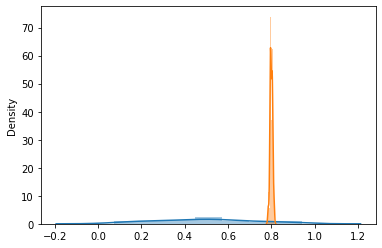

In [105]:
Model = pyro.condition(model(theta1_beta, theta2_beta), data={"y":y})
mcmc = compute_mcmc(Model,x, Kernel=NUTS)
plot_inference(mcmc)

In [84]:
theta = torch.tensor(0.2)
Model = pyro.condition(model(theta1_beta, theta2_beta), data={"y":y})
mcmc = compute_mcmc(Model,x, Kernel=NUTS)
plot_inference(mcmc)

Sample: 100%|██████████| 400/400 [00:03, 103.93it/s, step size=9.31e-01, acc. prob=0.923]


dict_keys(['theta_2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_2      0.80      0.01      0.80      0.79      0.81     34.44      1.08

Number of divergences: 0
None


KeyError: 'theta_1'

Sample: 100%|██████████| 306/306 [00:02, 125.29it/s, step size=8.91e-01, acc. prob=0.950]


dict_keys(['theta_1', 'theta_2'])

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   theta_1      0.47      0.07      0.49      0.39      0.54     15.92      0.86
   theta_2     -5.50      0.09     -5.55     -5.59     -5.35      2.66      2.20

Number of divergences: 0
None
expected theta1 = 0.4708993136882782
expected theta2 = -5.497020721435547


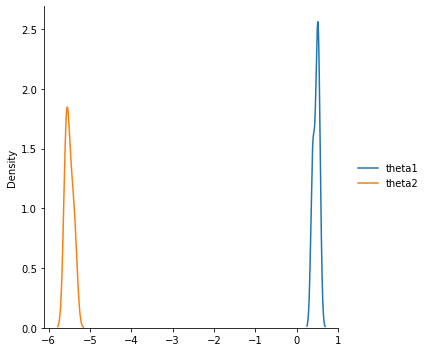

In [13]:
mcmc_gauss = compute_mcmc(model(theta1_gauss, theta2_gauss),x,y, Kernel=NUTS)
plot_inference(mcmc_gauss)

## Ex 2
----
### Exercise 2

A bivariate Gibbs sampler for a vector $x=(x_1,x_2)$ draws iteratively from the posterior conditional distributions in the following way:
- choose a starting value $p(x_1|x_2^{(0)})$
- for each iteration $i$:
    - draw $x_2(i)$ from $p(x_2|x_1^{(i-1)})$
    - draw $x_1(i)$ from $p(x_1|x_2^{(i)})$

a. Supposing that samples are drawn from a bivariate normal distribution

$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
    implement a Gibbs sampler function which takes as inputs the parameter `rho`, the number of iterations `iters` and the number of warmup draws `warmup`.

b. Use your implementation of Gibbs sampler to infer the parameters $\theta=(\theta_1,\theta_2)$ from **Exercise 1**.

----

If 
$$
{x_1 \choose x_2} \sim \mathcal{N} \Bigg[ {0 \choose 0} , \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix} \Bigg],
$$
then 
$$ p(x_1 | x_2 = a) \sim \mathcal{N}[\rho a, 1- r\rho^2] $$

In [61]:
Mo = model(theta1_beta, theta2_beta)
theta1 = 1.1
conditioned_model = pyro.condition(Mo, data={"y":y, "theta_1": theta1})
conditioned_model(x)


(tensor([ 58.7600, 108.7500,  25.0300,  20.0300,  47.5100,   6.3700]),
 1.1,
 tensor(0.4896))

In [98]:
def Gibbs_sampler(rho, iters, warmup):
    ''' Implement Gibbs sampling for bivariate normal distribution'''

    sigma = torch.Tensor([[1,rho], [rho,1]])
    x_2 = 1.1
    x_1 = 0.3
    X_1 = torch.zeros(iters)
    X_2 = torch.zeros(iters)
    for i in range(warmup):
        x_2 = pyro.sample("x_2", dist.Normal(x_1*rho, 1-rho**2))
        x_1 = pyro.sample("x_1", dist.Normal(x_2*rho, 1-rho**2))
    
    for i in range(iters):
        x_2 = pyro.sample("x_2", dist.Normal(x_1*rho, 1-rho**2))
        x_1 = pyro.sample("x_1", dist.Normal(x_2*rho, 1-rho**2))
        X_2[i] = x_2
        X_1[i] = x_1
    
    return X_1, X_2


def Gibbs_inferece(model, x, y, warmup, iters):
    ''' Implement Gibbs sampling for inference on theta1 and theta2'''
    X_1 = torch.zeros(iters)
    X_2 = torch.zeros(iters)
    z1 =torch.tensor(0.1)

    for i in range(warmup):
        conditioned_model = pyro.condition(model, data={"y":y, "theta_1": z1})
        
        _,_,z2 = conditioned_model(x) * 
        conditional_model = pyro.condition(model, data={"y":y, "theta_2": z2})
        _, z1, _ = conditional_model(x) * model(x)

    for i in range(iters):
        conditioned_model = pyro.condition(model, data={"y":y, "theta_1": z1})
        _,_,z2  = conditioned_model(x) * model(x)
        conditional_model = pyro.condition(model, data={"y":y, "theta_2": z2})
        _, z1, _ = conditional_model(x) * model(x)
        X_1[i] = z1
        X_2[i] = z2

    return X_1,X_2


def plot_gibbs(X1,X2):

    y_1 = np.reshape(X1.numpy(), X1.size()[0])
    y_2 = np.reshape(X2.numpy(), X2.size()[0])
    # fig, ax = plt.subplots(1, 2, figsize=(12,3))

    data = pd.DataFrame({"theta1":y_1, "theta2":y_2})
    sns.displot(data, kind="kde")

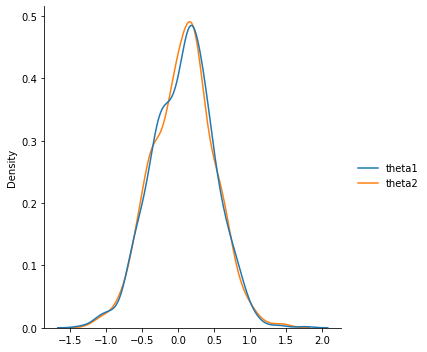

In [119]:
X_1, X_2 = Gibbs_sampler(0.9, 1000, 100)
plot_gibbs(X_1, X_2)

/tmp/ipykernel_76275/3910447631.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_gibbs(torch.tensor(X_1), torch.tensor(X_2))


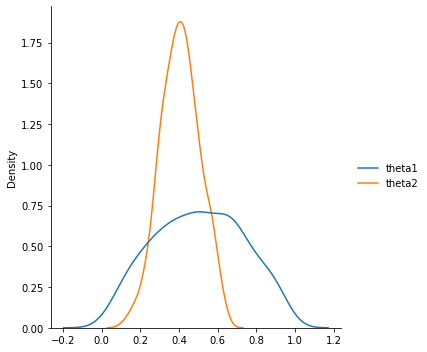

In [115]:
Model = model(theta1_beta, theta2_gauss)
X_1, X_2 = Gibbs_inferece(Model, x, y, warmup=1000, iters=500)
plot_gibbs(torch.tensor(X_1), torch.tensor(X_2))


In [128]:
from pyro.infer.autoguide import AutoGuide
guide = AutoGuide(Model)
guide()

NotImplementedError: 